# 0. GWSA experiments - setup & analysis
How reliably can we predict in the future at an unobserved location through a combination of prediction and interpolation?
Consider:

- GLDAS 2.2 CLSM

- ST DeepKriging

- 2D U-Net

- 3D U-Net

- g2p CNN (+ 2D Kriging)

- g2p CNN + LSTM (+ 2D Kriging)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd

from utils.helpers import *
from utils.metrics import *

import tensorflow as tf
from keras.callbacks import EarlyStopping

from sklearn.model_selection import TimeSeriesSplit

2025-11-26 18:14:13.246631: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 18:14:13.483032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Prepare data

In [2]:
root_path = './data/Bangladesh'
outputs_path = f'{root_path}/outputs'
lag = 5

bgd_shp = gpd.read_file(f'{root_path}/BGD_shp/vb025yv7599.shp')
info_file = pd.read_csv(f'{root_path}/target/well_info.csv')

##### 1.1. Read data

In [3]:
# predictors

full_era_ds = xr.open_mfdataset(f'{root_path}/inputs/PR_AET_M_2002_2017_BGD_025.nc4')
full_era_ds['time'] = [x + pd.DateOffset(days=14) for x in full_era_ds['time'].values ]
full_precip_da = full_era_ds['pr'][(lag-1):]
full_aet_da = full_era_ds['aet'][(lag-1):]

full_twsa_da = xr.open_mfdataset(f'{root_path}/inputs/TWSA_M_2002_2017_BGD_025.nc4')['twsa'][(lag-1):]
full_twsa_da['time'] = [x + pd.DateOffset(days=14) for x in full_twsa_da['time'].values ]

full_dem_da = xr.open_mfdataset(f'{root_path}/inputs/DEM_BGD_025.nc4')['dem'][0]
full_ndvi_da = xr.open_mfdataset(f'{root_path}/inputs/NDVI_M_2002_2017_BGD_025.nc4')['NDVI'][(lag-1):]
full_ndvi_da['time'] = [x + pd.DateOffset(days=14) for x in full_ndvi_da['time'].values ]

cov_das = [full_precip_da, full_aet_da, full_twsa_da, full_ndvi_da, full_dem_da]

In [4]:
# target
miss_ts = pd.read_csv(f"{root_path}/filtered_gws_ts_data_1961_2019.csv", parse_dates=['Date'], index_col='Date')
miss_ts = miss_ts['2002-04-01':'2017-05-31'].dropna(axis=1, how='all')
miss_ts_gwsa = (miss_ts - miss_ts['2004-01-01':'2009-12-31'].mean()).iloc[(lag-1):]

filled_ts = pd.read_csv(f"{root_path}/filtered_filled_missForest_gws_ts_data_1961_2019.csv", parse_dates=['Date'], index_col='Date')
filled_ts = filled_ts['2002-04-01':'2017-05-31'].dropna(axis=1, how='any')
filled_ts_gwsa = filled_ts - filled_ts['2004-01-01':'2009-12-31'].mean()

# gldas
gldas_22_ds = xr.open_dataset(f'{root_path}/GLDAS_22_CLSM_GWS_M_2003_2017_BGD_025.nc4')
# convert from mm to m
gldas22_gwsa_da = gldas_22_ds['gwsa']
gldas22_gwsa_da.rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'gwsa' (time: 172, lat: 26, lon: 24)> Size: 429kB
[107328 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1kB 2003-02-15 2003-03-15 ... 2017-05-15
  * lon      (lon) float64 192B 86.86 87.11 87.36 87.61 ... 92.11 92.36 92.61
  * lat      (lat) float64 208B 20.82 21.07 21.32 21.57 ... 26.57 26.82 27.07
Attributes:
    _FillValue:  nan

##### 1.2 Prepare interpolation testing set (hold out)

In [5]:
#### create an interpolation hold-out set
rng = np.random.default_rng()              # set a seed for reproducibility (optional)
n_cols = miss_ts_gwsa.shape[1]
idx = rng.choice(n_cols, size=int(0.05*n_cols), replace=False)
holdout_locs = idx.tolist()
holdout_locs.sort()
holdout_ids = miss_ts_gwsa.columns[holdout_locs]
train_locs = [i for i in range(filled_ts_gwsa.shape[1]) if filled_ts_gwsa.columns[i] not in holdout_ids]
train_ids = filled_ts_gwsa.columns[train_locs]

coords_train = np.array([ info_file[info_file['SegmentID'] == well][['Latitude', 'Longitude']].values[0] for well in train_ids ])
coords_ipol_test = np.array([ info_file[info_file['SegmentID'] == well][['Latitude', 'Longitude']].values[0] for well in holdout_ids ])

#miss_ts_gwsa[train_ids]

##### 1.3 Prepare cross-validation setup

In [ ]:
tscv = TimeSeriesSplit(n_splits=10, gap=0)

y = miss_ts_gwsa.to_numpy()

tr_idxs = []
test_idxs = []

for i, (tr_idx, test_idx) in enumerate(tscv.split(y)):
    tf.random.set_seed(50)
    tr_idxs.append(tr_idx)
    test_idxs.append(test_idx)

# save to use on individual models
cv_setup = {
    'train_ids': train_ids.values,
    'holdout_ids': holdout_ids.values,
    'tr_idxs': tr_idxs,
    'test_idxs': test_idxs,
    'seed': np.random.randint(100000)
}

#np.save(f'{root_path}/cv_setup.npy', cv_setup, allow_pickle=True)

#### 2. Read current cross validation setup

In [5]:
cv_setup = np.load(f'{root_path}/cv_setup.npy', allow_pickle=True).item()
train_ids = cv_setup['train_ids']
holdout_ids = cv_setup['holdout_ids']
tr_idxs = cv_setup['tr_idxs']
test_idxs = cv_setup['test_idxs']

coords_train = np.array([ info_file[info_file['SegmentID'] == well][['Latitude', 'Longitude']].values[0] for well in train_ids ])
coords_ipol_test = np.array([ info_file[info_file['SegmentID'] == well][['Latitude', 'Longitude']].values[0] for well in holdout_ids ])

#### 3. Evaluate

In [6]:
dk_ds = []

for i in range(0,10):
    dk_ipol_da = xr.open_dataset(f'{outputs_path}/DeepKriging/st_deepkrig_all_cov_ipol_fold_{i}.nc4')
    mapping = {"0.1": 0.1, "0.5": 0.5, "0.9": 0.9}
    new_index = dk_ipol_da.get_index('quantile').map(mapping).astype(np.float64)
    dk_ipol_da_fix = dk_ipol_da.assign_coords({'quantile': new_index})
    dk_fcst_ds = xr.open_dataset(f'{outputs_path}/DeepKriging/st_deepkrig_all_cov_fcst_fold_{i}.nc4')
    dk_ds.append(xr.concat([dk_ipol_da_fix, dk_fcst_ds], 'time')['gwsa_pred'])

unet_2d_ds = [ xr.open_dataset(f'{outputs_path}/2D_Unet/2d_unet_filled_gwsa_fold_{i}.nc4')['gwsa_pred'] for i in range(0,10) ]
unet_3d_ds = [ xr.open_dataset(f'{outputs_path}/3D_Unet/3d_unet_filled_gwsa_{lag}m_fold_{i}.nc4')['gwsa_pred'] for i in range(0,10) ]
cnn_lstm_point_ds = [ np.load(f'{outputs_path}/g2p_CNN_LSTM/g2p_cnn_lstm_point_gwsa_{lag}m_fold_{i}.npy') for i in range(0,10) ]
cnn_point_ds = [ np.load(f'{outputs_path}/g2p_CNN/g2p_cnn_point_gwsa_fold_{i}.npy') for i in range(0,10) ]
cnn_krig_ds = [ xr.open_dataset(f'{outputs_path}/g2p_CNN_Kriging/g2p_cnn_krig_filled_gwsa_fold_{i}.nc4')['gwsa'] for i in range(0,10) ]
cnn_lstm_krig_ds = [ xr.open_dataset(f'{outputs_path}/g2p_CNN_LSTM_Kriging/g2p_cnn_lstm_krig_filled_gwsa_{lag}m_fold_{i}.nc4')['gwsa'] for i in range(0,10) ]

In [7]:
pred_point_coords_ids = np.load(f'{root_path}/target/predicted_point_coords_ids.npy')
pp_ids, pp_coords = zip(*[(item[0], (item[1], item[2])) for item in pred_point_coords_ids])

pp_ids = list(pp_ids)
pp_coords_l = list(pp_coords)
pp_coords = np.array(pp_coords_l)

In [8]:
dk_r2_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
unet_2d_r2_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
unet_3d_r2_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_krig_r2_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_lstm_krig_r2_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_point_r2_scores = { 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_lstm_point_r2_scores = { 'prediction': { 'tr': [], 'val': [], 'ts': [] } }

for i in range (0,len(dk_ds)):

    tr_idx = tr_idxs[i]
    v = test_idxs[i]
    mid = len(v) // 2
    val_idx, ts_idx = v[:mid], v[mid:]

    for s in ['tr', 'val', 'ts']:
        globals()[f"obs_pred_point_{s}"] = miss_ts_gwsa[pp_ids].to_numpy()[globals()[f"{s}_idx"] ]
        globals()[f"obs_ipol_point_{s}"] = miss_ts_gwsa[holdout_ids].to_numpy()[globals()[f"{s}_idx"] ]

        dk_r2_scores['prediction'][s].append(xr_global_point_R2(globals()[f"obs_pred_point_{s}"], pp_coords, dk_ds[i][globals()[f"{s}_idx"], :, :, 1]))
        unet_2d_r2_scores['prediction'][s].append(xr_global_point_R2(globals()[f"obs_pred_point_{s}"], pp_coords, unet_2d_ds[i][globals()[f"{s}_idx"] ]))
        unet_3d_r2_scores['prediction'][s].append(xr_global_point_R2(globals()[f"obs_pred_point_{s}"], pp_coords, unet_3d_ds[i][globals()[f"{s}_idx"] ]))        
        cnn_krig_r2_scores['prediction'][s].append(xr_global_point_R2(globals()[f"obs_pred_point_{s}"], pp_coords, cnn_krig_ds[i][globals()[f"{s}_idx"] ]))
        cnn_lstm_krig_r2_scores['prediction'][s].append(xr_global_point_R2(globals()[f"obs_pred_point_{s}"], pp_coords, cnn_lstm_krig_ds[i][globals()[f"{s}_idx"] ]))
        cnn_point_r2_scores['prediction'][s].append(calculate_global_R2(globals()[f"obs_pred_point_{s}"], cnn_point_ds[i][globals()[f"{s}_idx"] ]))
        cnn_lstm_point_r2_scores['prediction'][s].append(calculate_global_R2(globals()[f"obs_pred_point_{s}"], cnn_lstm_point_ds[i][globals()[f"{s}_idx"] ]))

        dk_r2_scores['interpolation'][s].append(xr_global_point_R2(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, dk_ds[i][globals()[f"{s}_idx"], :, :, 1]))
        unet_2d_r2_scores['interpolation'][s].append(xr_global_point_R2(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, unet_2d_ds[i][globals()[f"{s}_idx"] ]))
        unet_3d_r2_scores['interpolation'][s].append(xr_global_point_R2(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, unet_3d_ds[i][globals()[f"{s}_idx"] ]))        
        cnn_krig_r2_scores['interpolation'][s].append(xr_global_point_R2(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, cnn_krig_ds[i][globals()[f"{s}_idx"] ]))
        cnn_lstm_krig_r2_scores['interpolation'][s].append(xr_global_point_R2(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, cnn_lstm_krig_ds[i][globals()[f"{s}_idx"] ]))


In [18]:
dk_mse_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
unet_2d_mse_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
unet_3d_mse_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_krig_mse_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_lstm_krig_mse_scores = { 'interpolation': { 'tr': [], 'val': [], 'ts': [] }, 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_point_mse_scores = { 'prediction': { 'tr': [], 'val': [], 'ts': [] } }
cnn_lstm_point_mse_scores = { 'prediction': { 'tr': [], 'val': [], 'ts': [] } }

for i in range (0,len(dk_ds)):

    tr_idx = tr_idxs[i]
    v = test_idxs[i]
    mid = len(v) // 2
    val_idx, ts_idx = v[:mid], v[mid:]

    for s in ['tr', 'val', 'ts']:
        globals()[f"obs_pred_point_{s}"] = miss_ts_gwsa[pp_ids].to_numpy()[globals()[f"{s}_idx"] ]
        globals()[f"obs_ipol_point_{s}"] = miss_ts_gwsa[holdout_ids].to_numpy()[globals()[f"{s}_idx"] ]

        dk_mse_scores['prediction'][s].append(round(xr_global_point_MSE(globals()[f"obs_pred_point_{s}"], pp_coords, dk_ds[i][globals()[f"{s}_idx"], :, :, 1]), 5))
        unet_2d_mse_scores['prediction'][s].append(round(xr_global_point_MSE(globals()[f"obs_pred_point_{s}"], pp_coords, unet_2d_ds[i][globals()[f"{s}_idx"] ]),4))
        unet_3d_mse_scores['prediction'][s].append(round(xr_global_point_MSE(globals()[f"obs_pred_point_{s}"], pp_coords, unet_3d_ds[i][globals()[f"{s}_idx"] ]),4))        
        cnn_krig_mse_scores['prediction'][s].append(round(xr_global_point_MSE(globals()[f"obs_pred_point_{s}"], pp_coords, cnn_krig_ds[i][globals()[f"{s}_idx"] ]),4))
        cnn_lstm_krig_mse_scores['prediction'][s].append(round(xr_global_point_MSE(globals()[f"obs_pred_point_{s}"], pp_coords, cnn_lstm_krig_ds[i][globals()[f"{s}_idx"] ]),4))
        cnn_point_mse_scores['prediction'][s].append(round(calculate_global_MSE(globals()[f"obs_pred_point_{s}"], cnn_point_ds[i][globals()[f"{s}_idx"] ]),4))
        cnn_lstm_point_mse_scores['prediction'][s].append(round(calculate_global_MSE(globals()[f"obs_pred_point_{s}"], cnn_lstm_point_ds[i][globals()[f"{s}_idx"] ]),4))

        dk_mse_scores['interpolation'][s].append(round(xr_global_point_MSE(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, dk_ds[i][globals()[f"{s}_idx"], :, :, 1]),4))
        unet_2d_mse_scores['interpolation'][s].append(round(xr_global_point_MSE(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, unet_2d_ds[i][globals()[f"{s}_idx"] ]),4))
        unet_3d_mse_scores['interpolation'][s].append(round(xr_global_point_MSE(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, unet_3d_ds[i][globals()[f"{s}_idx"] ]),4))        
        cnn_krig_mse_scores['interpolation'][s].append(round(xr_global_point_MSE(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, cnn_krig_ds[i][globals()[f"{s}_idx"] ]),4))
        cnn_lstm_krig_mse_scores['interpolation'][s].append(round(xr_global_point_MSE(globals()[f"obs_ipol_point_{s}"], coords_ipol_test, cnn_lstm_krig_ds[i][globals()[f"{s}_idx"] ]),4))


In [30]:
data = {
    ('prediction', 'train', 'mean'): [],
    ('prediction', 'train', 'std'): [],
    ('prediction', 'val', 'mean'): [],
    ('prediction', 'val', 'std'): [],
    ('prediction', 'test', 'mean'): [],
    ('prediction', 'test', 'std'): [],
    
    ('interpolation', 'train', 'mean'): [],
    ('interpolation', 'train', 'std'): [],
    ('interpolation', 'val', 'mean'): [],
    ('interpolation', 'val', 'std'): [],
    ('interpolation', 'test', 'mean'): [],
    ('interpolation', 'test', 'std'): []
}

# methods (rows)
methods = ['DeepKriging', 'GLDAS 2.2', '2D Unet', '3D Unet', 'CNN+Kriging', 
           'CNN_LSTM_Kriging', '[g2p] CNN', '[g2p] CNN_LSTM']

# prediction
data[('prediction', 'train','mean')].extend(
    [
        np.mean(dk_r2_scores['prediction']['tr']),
        xr_global_point_R2(obs_pred_point_tr[6:], pp_coords, gldas22_gwsa_da[tr_idx[:-6]]),
        np.mean(unet_2d_r2_scores['prediction']['tr']), np.mean(unet_3d_r2_scores['prediction']['tr']),
        np.mean(cnn_krig_r2_scores['prediction']['tr']), np.mean(cnn_lstm_krig_r2_scores['prediction']['tr']),
        np.mean(cnn_point_r2_scores['prediction']['tr']), np.mean(cnn_lstm_point_r2_scores['prediction']['tr'])
    ]
)

data[('prediction', 'train', 'std')].extend(
    [
        np.std(dk_r2_scores['prediction']['tr']),
        np.nan,
        np.std(unet_2d_r2_scores['prediction']['tr']), np.std(unet_3d_r2_scores['prediction']['tr']),
        np.std(cnn_krig_r2_scores['prediction']['tr']), np.std(cnn_lstm_krig_r2_scores['prediction']['tr']),
        np.std(cnn_point_r2_scores['prediction']['tr']), np.std(cnn_lstm_point_r2_scores['prediction']['tr'])
    ]
)

data[('prediction', 'val', 'mean')].extend(
    [
        np.mean(dk_r2_scores['prediction']['val']),
        xr_global_point_R2(obs_pred_point_val, pp_coords, gldas22_gwsa_da[val_idx - 6]),
        np.mean(unet_2d_r2_scores['prediction']['val']), np.mean(unet_3d_r2_scores['prediction']['val']),
        np.mean(cnn_krig_r2_scores['prediction']['val']), np.mean(cnn_lstm_krig_r2_scores['prediction']['val']),
        np.mean(cnn_point_r2_scores['prediction']['val']), np.mean(cnn_lstm_point_r2_scores['prediction']['val'])
    ]
)
data[('prediction', 'val', 'std')].extend(
    [
        np.std(dk_r2_scores['prediction']['val']),
        np.nan,
        np.std(unet_2d_r2_scores['prediction']['val']), np.std(unet_3d_r2_scores['prediction']['val']),
        np.std(cnn_krig_r2_scores['prediction']['val']), np.std(cnn_lstm_krig_r2_scores['prediction']['val']),
        np.std(cnn_point_r2_scores['prediction']['val']), np.std(cnn_lstm_point_r2_scores['prediction']['val'])
    ]
)
data[('prediction', 'test', 'mean')].extend(
    [
        np.mean(dk_r2_scores['prediction']['ts']),
        xr_global_point_R2(obs_pred_point_ts, pp_coords, gldas22_gwsa_da[ts_idx - 6]),
        np.mean(unet_2d_r2_scores['prediction']['ts']), np.mean(unet_3d_r2_scores['prediction']['ts']),
        np.mean(cnn_krig_r2_scores['prediction']['ts']), np.mean(cnn_lstm_krig_r2_scores['prediction']['ts']),
        np.mean(cnn_point_r2_scores['prediction']['ts']), np.mean(cnn_lstm_point_r2_scores['prediction']['ts'])
    ]
)

data[('prediction', 'test', 'std')].extend(
    [
        np.std(dk_r2_scores['prediction']['ts']),
        np.nan,
        np.std(unet_2d_r2_scores['prediction']['ts']), np.std(unet_3d_r2_scores['prediction']['ts']),
        np.std(cnn_krig_r2_scores['prediction']['ts']), np.std(cnn_lstm_krig_r2_scores['prediction']['ts']),
        np.std(cnn_point_r2_scores['prediction']['ts']), np.std(cnn_lstm_point_r2_scores['prediction']['ts'])
    ]
)

# interpolation
data[('interpolation', 'train', 'mean')].extend(
    [
        np.mean(dk_r2_scores['interpolation']['tr']),
        xr_global_point_R2(obs_pred_point_tr[6:], pp_coords, gldas22_gwsa_da[tr_idx[:-6]]),
        np.mean(unet_2d_r2_scores['interpolation']['tr']), np.mean(unet_3d_r2_scores['interpolation']['tr']),
        np.mean(cnn_krig_r2_scores['interpolation']['tr']), np.mean(cnn_lstm_krig_r2_scores['interpolation']['tr']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'train', 'std')].extend(
    [
        np.std(dk_r2_scores['interpolation']['tr']),
        np.nan,
        np.std(unet_2d_r2_scores['interpolation']['tr']), np.std(unet_3d_r2_scores['interpolation']['tr']),
        np.std(cnn_krig_r2_scores['interpolation']['tr']), np.std(cnn_lstm_krig_r2_scores['interpolation']['tr']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'val', 'mean')].extend(
    [
        np.mean(dk_r2_scores['interpolation']['val']),
        xr_global_point_R2(obs_ipol_point_val, coords_ipol_test, gldas22_gwsa_da[val_idx - 6]),
        np.mean(unet_2d_r2_scores['interpolation']['val']), np.mean(unet_3d_r2_scores['interpolation']['val']),
        np.mean(cnn_krig_r2_scores['interpolation']['val']), np.mean(cnn_lstm_krig_r2_scores['interpolation']['val']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'val', 'std')].extend(
    [
        np.std(dk_r2_scores['interpolation']['val']),
        np.nan,
        np.std(unet_2d_r2_scores['interpolation']['val']), np.std(unet_3d_r2_scores['interpolation']['val']),
        np.std(cnn_krig_r2_scores['interpolation']['val']), np.std(cnn_lstm_krig_r2_scores['interpolation']['val']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'test', 'mean')].extend(
    [
        np.mean(dk_r2_scores['interpolation']['ts']),
        xr_global_point_R2(obs_ipol_point_ts, coords_ipol_test, gldas22_gwsa_da[ts_idx - 6]),
        np.mean(unet_2d_r2_scores['interpolation']['ts']), np.mean(unet_3d_r2_scores['interpolation']['ts']),
        np.mean(cnn_krig_r2_scores['interpolation']['ts']), np.mean(cnn_lstm_krig_r2_scores['interpolation']['ts']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'test', 'std')].extend(
    [
        np.std(dk_r2_scores['interpolation']['ts']),
        np.nan,
        np.std(unet_2d_r2_scores['interpolation']['ts']), np.std(unet_3d_r2_scores['interpolation']['ts']),
        np.std(cnn_krig_r2_scores['interpolation']['ts']), np.std(cnn_lstm_krig_r2_scores['interpolation']['ts']),
        np.nan,np.nan
    ]
)

# Create MultiIndex DataFrame
df = pd.DataFrame(data, index=methods).round(2)

print('============= R2 ===================')
# Display the DataFrame
df

============= R2 ===================


prediction                               interpolation        \
                      train         val        test               train         
                       mean   std  mean   std  mean   std          mean   std   
DeepKriging            0.66  0.02  0.57  0.10  0.02  0.28          0.61  0.03   
GLDAS 2.2              0.08   NaN -0.05   NaN -0.11   NaN          0.08   NaN   
2D Unet                0.60  0.04  0.44  0.12  0.48  0.08          0.58  0.04   
3D Unet                0.58  0.07  0.45  0.10  0.45  0.06          0.57  0.07   
CNN+Kriging            0.65  0.02  0.50  0.13  0.49  0.10          0.61  0.03   
CNN_LSTM_Kriging       0.65  0.02  0.49  0.12  0.49  0.07          0.61  0.03   
[g2p] CNN              0.87  0.02  0.69  0.14  0.65  0.09           NaN   NaN   
[g2p] CNN_LSTM         0.85  0.02  0.67  0.12  0.64  0.07           NaN   NaN   

                                          
                   val        test        
                  mean   std  mean   std  
DeepKriging       0.46  0.16 -0.02  0.31  
GLDAS 2.2        -0.80   NaN -0.44   NaN  
2D Unet           0.38  0.17  0.45  0.12  
3D Unet           0.41  0.14  0.44  0.10  
CNN+Kriging       0.40  0.17  0.43  0.13  
CNN_LSTM_Kriging  0.41  0.16  0.44  0.11  
[g2p] CNN          NaN   NaN   NaN   NaN  
[g2p] CNN_LSTM     NaN   NaN   NaN   NaN

In [34]:
data = {
    ('prediction', 'train', 'mean'): [],
    ('prediction', 'train', 'std'): [],
    ('prediction', 'val', 'mean'): [],
    ('prediction', 'val', 'std'): [],
    ('prediction', 'test', 'mean'): [],
    ('prediction', 'test', 'std'): [],
    
    ('interpolation', 'train', 'mean'): [],
    ('interpolation', 'train', 'std'): [],
    ('interpolation', 'val', 'mean'): [],
    ('interpolation', 'val', 'std'): [],
    ('interpolation', 'test', 'mean'): [],
    ('interpolation', 'test', 'std'): []
}

# methods (rows)
methods = ['DeepKriging', 'GLDAS 2.2', '2D Unet', '3D Unet', 'CNN+Kriging', 
           'CNN_LSTM_Kriging', '[g2p] CNN', '[g2p] CNN_LSTM']

# prediction
data[('prediction', 'train','mean')].extend(
    [
        np.mean(dk_mse_scores['prediction']['tr']),
        xr_global_point_MSE(obs_pred_point_tr[6:], pp_coords, gldas22_gwsa_da[tr_idx[:-6]]),
        np.mean(unet_2d_mse_scores['prediction']['tr']), np.mean(unet_3d_mse_scores['prediction']['tr']),
        np.mean(cnn_krig_mse_scores['prediction']['tr']), np.mean(cnn_lstm_krig_mse_scores['prediction']['tr']),
        np.mean(cnn_point_mse_scores['prediction']['tr']), np.mean(cnn_lstm_point_mse_scores['prediction']['tr'])
    ]
)

data[('prediction', 'train', 'std')].extend(
    [
        np.std(dk_mse_scores['prediction']['tr']),
        np.nan,
        np.std(unet_2d_mse_scores['prediction']['tr']), np.std(unet_3d_mse_scores['prediction']['tr']),
        np.std(cnn_krig_mse_scores['prediction']['tr']), np.std(cnn_lstm_krig_mse_scores['prediction']['tr']),
        np.std(cnn_point_mse_scores['prediction']['tr']), np.std(cnn_lstm_point_mse_scores['prediction']['tr'])
    ]
)

data[('prediction', 'val', 'mean')].extend(
    [
        np.mean(dk_mse_scores['prediction']['val']),
        xr_global_point_MSE(obs_pred_point_val, pp_coords, gldas22_gwsa_da[val_idx - 6]),
        np.mean(unet_2d_mse_scores['prediction']['val']), np.mean(unet_3d_mse_scores['prediction']['val']),
        np.mean(cnn_krig_mse_scores['prediction']['val']), np.mean(cnn_lstm_krig_mse_scores['prediction']['val']),
        np.mean(cnn_point_mse_scores['prediction']['val']), np.mean(cnn_lstm_point_mse_scores['prediction']['val'])
    ]
)
data[('prediction', 'val', 'std')].extend(
    [
        np.std(dk_mse_scores['prediction']['val']),
        np.nan,
        np.std(unet_2d_mse_scores['prediction']['val']), np.std(unet_3d_mse_scores['prediction']['val']),
        np.std(cnn_krig_mse_scores['prediction']['val']), np.std(cnn_lstm_krig_mse_scores['prediction']['val']),
        np.std(cnn_point_mse_scores['prediction']['val']), np.std(cnn_lstm_point_mse_scores['prediction']['val'])
    ]
)
data[('prediction', 'test', 'mean')].extend(
    [
        np.mean(dk_mse_scores['prediction']['ts']),
        xr_global_point_MSE(obs_pred_point_ts, pp_coords, gldas22_gwsa_da[ts_idx - 6]),
        np.mean(unet_2d_mse_scores['prediction']['ts']), np.mean(unet_3d_mse_scores['prediction']['ts']),
        np.mean(cnn_krig_mse_scores['prediction']['ts']), np.mean(cnn_lstm_krig_mse_scores['prediction']['ts']),
        np.mean(cnn_point_mse_scores['prediction']['ts']), np.mean(cnn_lstm_point_mse_scores['prediction']['ts'])
    ]
)

data[('prediction', 'test', 'std')].extend(
    [
        np.std(dk_mse_scores['prediction']['ts']),
        np.nan,
        np.std(unet_2d_mse_scores['prediction']['ts']), np.std(unet_3d_mse_scores['prediction']['ts']),
        np.std(cnn_krig_mse_scores['prediction']['ts']), np.std(cnn_lstm_krig_mse_scores['prediction']['ts']),
        np.std(cnn_point_mse_scores['prediction']['ts']), np.std(cnn_lstm_point_mse_scores['prediction']['ts'])
    ]
)

# interpolation
data[('interpolation', 'train', 'mean')].extend(
    [
        np.mean(dk_mse_scores['interpolation']['tr']),
        xr_global_point_MSE(obs_pred_point_tr[6:], pp_coords, gldas22_gwsa_da[tr_idx[:-6]]),
        np.mean(unet_2d_mse_scores['interpolation']['tr']), np.mean(unet_3d_mse_scores['interpolation']['tr']),
        np.mean(cnn_krig_mse_scores['interpolation']['tr']), np.mean(cnn_lstm_krig_mse_scores['interpolation']['tr']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'train', 'std')].extend(
    [
        np.std(dk_mse_scores['interpolation']['tr']),
        np.nan,
        np.std(unet_2d_mse_scores['interpolation']['tr']), np.std(unet_3d_mse_scores['interpolation']['tr']),
        np.std(cnn_krig_mse_scores['interpolation']['tr']), np.std(cnn_lstm_krig_mse_scores['interpolation']['tr']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'val', 'mean')].extend(
    [
        np.mean(dk_mse_scores['interpolation']['val']),
        xr_global_point_MSE(obs_ipol_point_val, coords_ipol_test, gldas22_gwsa_da[val_idx - 6]),
        np.mean(unet_2d_mse_scores['interpolation']['val']), np.mean(unet_3d_mse_scores['interpolation']['val']),
        np.mean(cnn_krig_mse_scores['interpolation']['val']), np.mean(cnn_lstm_krig_mse_scores['interpolation']['val']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'val', 'std')].extend(
    [
        np.std(dk_mse_scores['interpolation']['val']),
        np.nan,
        np.std(unet_2d_mse_scores['interpolation']['val']), np.std(unet_3d_mse_scores['interpolation']['val']),
        np.std(cnn_krig_mse_scores['interpolation']['val']), np.std(cnn_lstm_krig_mse_scores['interpolation']['val']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'test', 'mean')].extend(
    [
        np.mean(dk_mse_scores['interpolation']['ts']),
        xr_global_point_MSE(obs_ipol_point_ts, coords_ipol_test, gldas22_gwsa_da[ts_idx - 6]),
        np.mean(unet_2d_mse_scores['interpolation']['ts']), np.mean(unet_3d_mse_scores['interpolation']['ts']),
        np.mean(cnn_krig_mse_scores['interpolation']['ts']), np.mean(cnn_lstm_krig_mse_scores['interpolation']['ts']),
        np.nan, np.nan
    ]
)
data[('interpolation', 'test', 'std')].extend(
    [
        np.std(dk_mse_scores['interpolation']['ts']),
        np.nan,
        np.std(unet_2d_mse_scores['interpolation']['ts']), np.std(unet_3d_mse_scores['interpolation']['ts']),
        np.std(cnn_krig_mse_scores['interpolation']['ts']), np.std(cnn_lstm_krig_mse_scores['interpolation']['ts']),
        np.nan,np.nan
    ]
)

# Create MultiIndex DataFrame
df = pd.DataFrame(data, index=methods).round(4)

print('============= MSE ===================')
# Display the DataFrame
df

============= MSE ===================


prediction                                          \
                      train             val            test           
                       mean     std    mean     std    mean     std   
DeepKriging          0.0046  0.0004  0.0052  0.0020  0.0123  0.0044   
GLDAS 2.2            0.0123     NaN  0.0205     NaN  0.0165     NaN   
2D Unet              0.0053  0.0007  0.0065  0.0022  0.0065  0.0018   
3D Unet              0.0055  0.0009  0.0066  0.0023  0.0068  0.0014   
CNN+Kriging          0.0046  0.0003  0.0059  0.0021  0.0063  0.0018   
CNN_LSTM_Kriging     0.0047  0.0004  0.0060  0.0020  0.0063  0.0016   
[g2p] CNN            0.0017  0.0003  0.0035  0.0011  0.0043  0.0013   
[g2p] CNN_LSTM       0.0019  0.0002  0.0037  0.0010  0.0043  0.0009   

                 interpolation                                          
                         train             val            test          
                          mean     std    mean     std    mean     std  
DeepKriging             0.0039  0.0004  0.0049  0.0018  0.0093  0.0035  
GLDAS 2.2               0.0123     NaN  0.0180     NaN  0.0148     NaN  
2D Unet                 0.0042  0.0005  0.0055  0.0017  0.0050  0.0015  
3D Unet                 0.0043  0.0008  0.0053  0.0017  0.0050  0.0012  
CNN+Kriging             0.0039  0.0003  0.0054  0.0015  0.0051  0.0013  
CNN_LSTM_Kriging        0.0039  0.0003  0.0053  0.0015  0.0050  0.0011  
[g2p] CNN                  NaN     NaN     NaN     NaN     NaN     NaN  
[g2p] CNN_LSTM             NaN     NaN     NaN     NaN     NaN     NaN

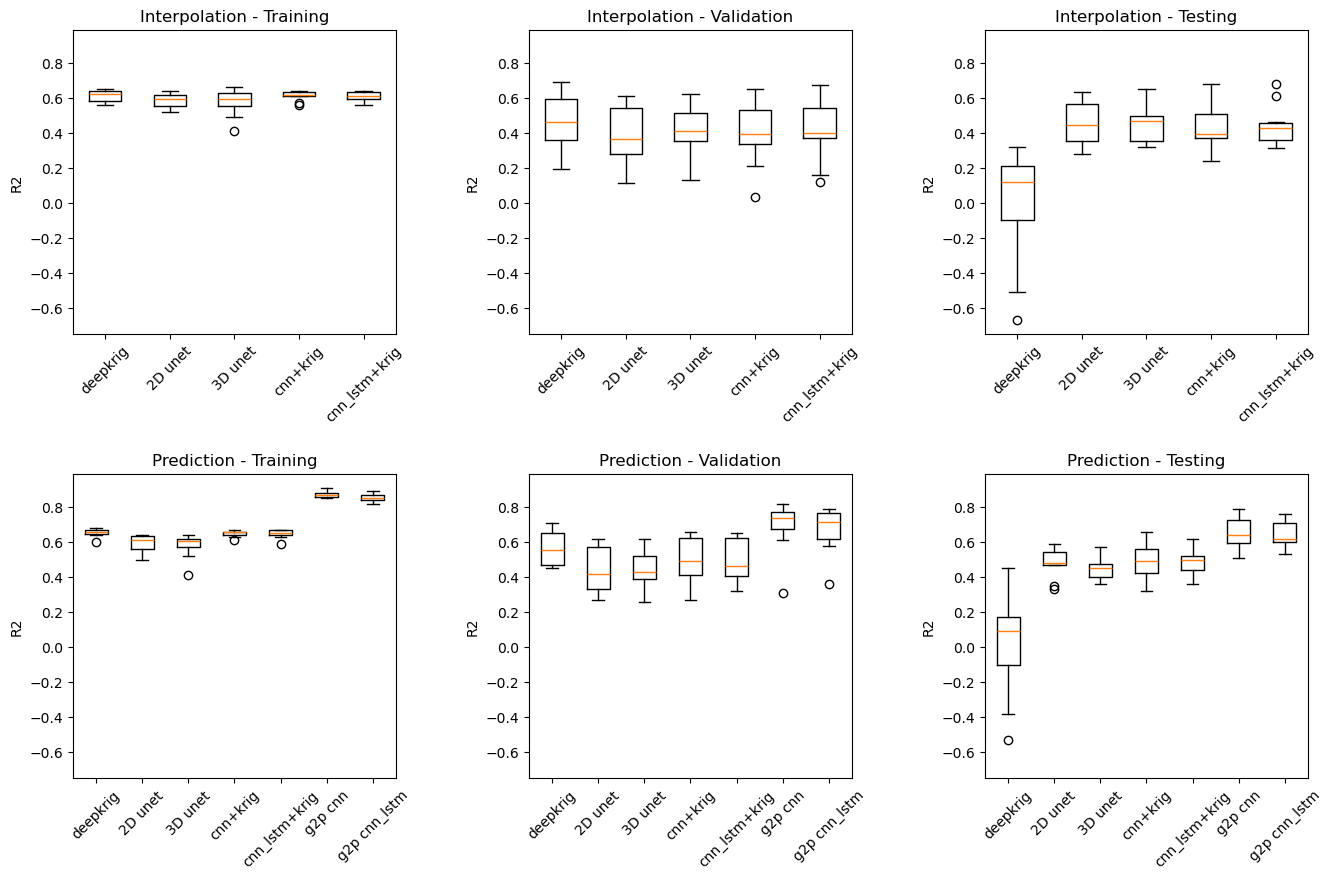

In [36]:
# plot prediction & interpolation depending on the fold
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=3, sharey=True)
fig.tight_layout(pad=8)
k = range(1,11)

inter_tr = []
inter_val = []
inter_ts = []
pred_tr = []
pred_val = []
pred_ts = []

for (label, scores) in [('deepkrig', dk_r2_scores), ('2D Unet', unet_2d_r2_scores), 
                ('3D Unet', unet_3d_r2_scores), ('CNN + krig', cnn_krig_r2_scores), 
                ('CNN_LSTM + krig', cnn_lstm_krig_r2_scores), ('g2p CNN', cnn_point_r2_scores), 
                ('g2p CNN_LSTM', cnn_lstm_point_r2_scores)]:
    if not label.startswith('g2p'):
        inter_tr.append(scores['interpolation']['tr'])
        inter_val.append(scores['interpolation']['val'])
        inter_ts.append(scores['interpolation']['ts'])

    pred_tr.append(scores['prediction']['tr'])
    pred_val.append(scores['prediction']['val'])
    pred_ts.append(scores['prediction']['ts'])

axs[0,0].boxplot(inter_tr)
axs[0,1].boxplot(inter_val)
axs[0,2].boxplot(inter_ts)

axs[1,0].boxplot(pred_tr)
axs[1,1].boxplot(pred_val)
axs[1,2].boxplot(pred_ts)

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        ax.set_xticks(range(1,6), ['deepkrig', '2D unet', '3D unet', 'cnn+krig', 'cnn_lstm+krig'],
                      rotation=45)
    else:
        ax.set_xticks(range(1,8), ['deepkrig', '2D unet', '3D unet', 'cnn+krig', 'cnn_lstm+krig',
                              'g2p cnn', 'g2p cnn_lstm'], rotation=45)
    ax.set_ylabel('R2')
    ax.tick_params(axis='y', which='both', labelleft=True)  # show on the left


axs[0,0].set_title('Interpolation - Training')
axs[1,0].set_title('Prediction - Training')
axs[0,1].set_title('Interpolation - Validation')
axs[1,1].set_title('Prediction - Validation')
axs[0,2].set_title('Interpolation - Testing')
axs[1,2].set_title('Prediction - Testing')

fig.savefig('./figs/fold_r2_scores_box.png', bbox_inches='tight', pad_inches=0)

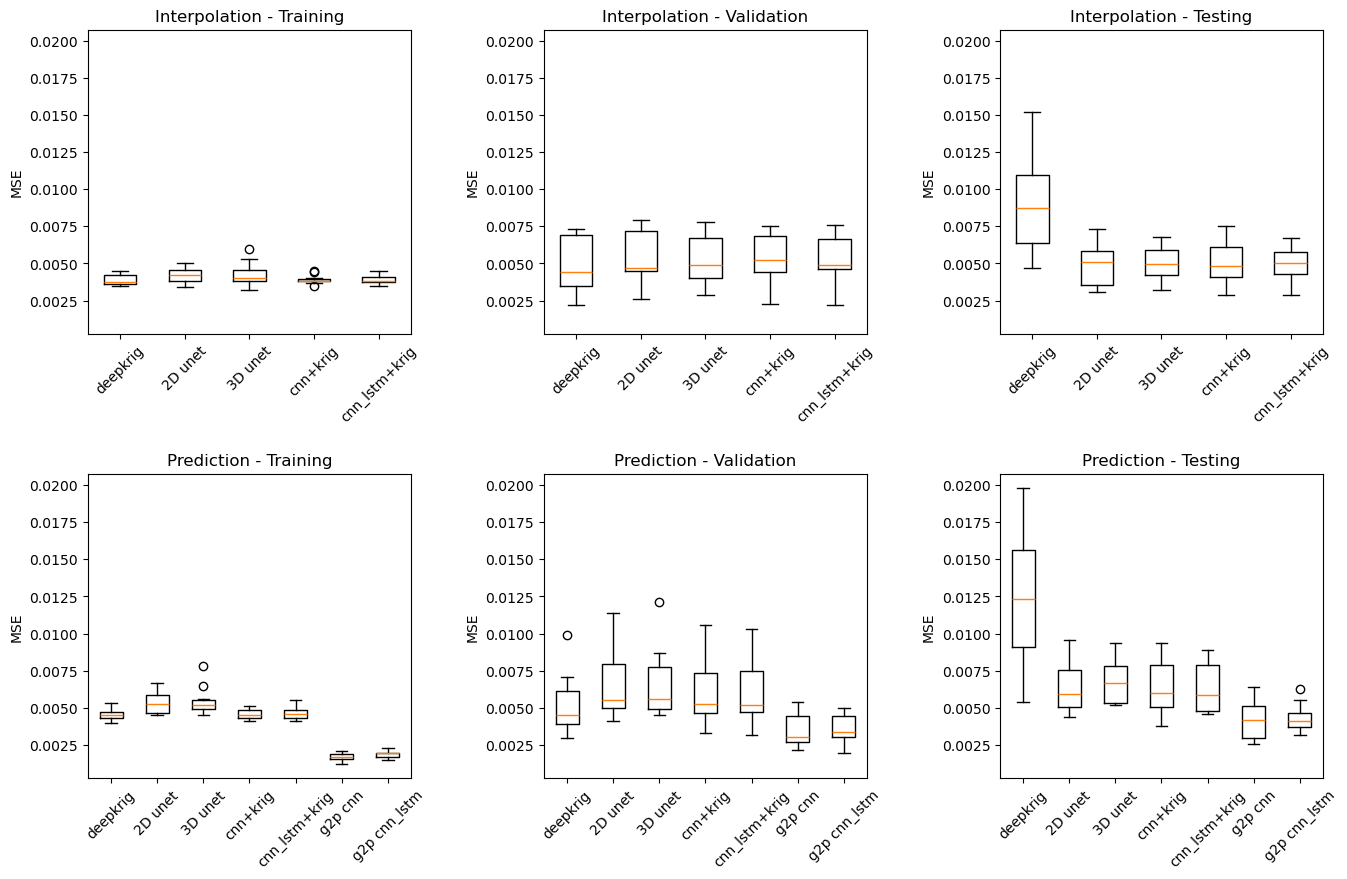

In [35]:
# plot prediction & interpolation depending on the fold
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=3, sharey=True)
fig.tight_layout(pad=8)
k = range(1,11)

inter_tr = []
inter_val = []
inter_ts = []
pred_tr = []
pred_val = []
pred_ts = []

for (label, scores) in [('deepkrig', dk_mse_scores), ('2D Unet', unet_2d_mse_scores), 
                ('3D Unet', unet_3d_mse_scores), ('CNN + krig', cnn_krig_mse_scores), 
                ('CNN_LSTM + krig', cnn_lstm_krig_mse_scores), ('g2p CNN', cnn_point_mse_scores), 
                ('g2p CNN_LSTM', cnn_lstm_point_mse_scores)]:
    if not label.startswith('g2p'):
        inter_tr.append(scores['interpolation']['tr'])
        inter_val.append(scores['interpolation']['val'])
        inter_ts.append(scores['interpolation']['ts'])

    pred_tr.append(scores['prediction']['tr'])
    pred_val.append(scores['prediction']['val'])
    pred_ts.append(scores['prediction']['ts'])

axs[0,0].boxplot(inter_tr)
axs[0,1].boxplot(inter_val)
axs[0,2].boxplot(inter_ts)

axs[1,0].boxplot(pred_tr)
axs[1,1].boxplot(pred_val)
axs[1,2].boxplot(pred_ts)

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        ax.set_xticks(range(1,6), ['deepkrig', '2D unet', '3D unet', 'cnn+krig', 'cnn_lstm+krig'],
                      rotation=45)
    else:
        ax.set_xticks(range(1,8), ['deepkrig', '2D unet', '3D unet', 'cnn+krig', 'cnn_lstm+krig',
                              'g2p cnn', 'g2p cnn_lstm'], rotation=45)
    ax.set_ylabel('MSE')
    ax.tick_params(axis='y', which='both', labelleft=True)  # show on the left


axs[0,0].set_title('Interpolation - Training')
axs[1,0].set_title('Prediction - Training')
axs[0,1].set_title('Interpolation - Validation')
axs[1,1].set_title('Prediction - Validation')
axs[0,2].set_title('Interpolation - Testing')
axs[1,2].set_title('Prediction - Testing')

fig.savefig('./figs/fold_mse_scores_box.png', bbox_inches='tight', pad_inches=0)

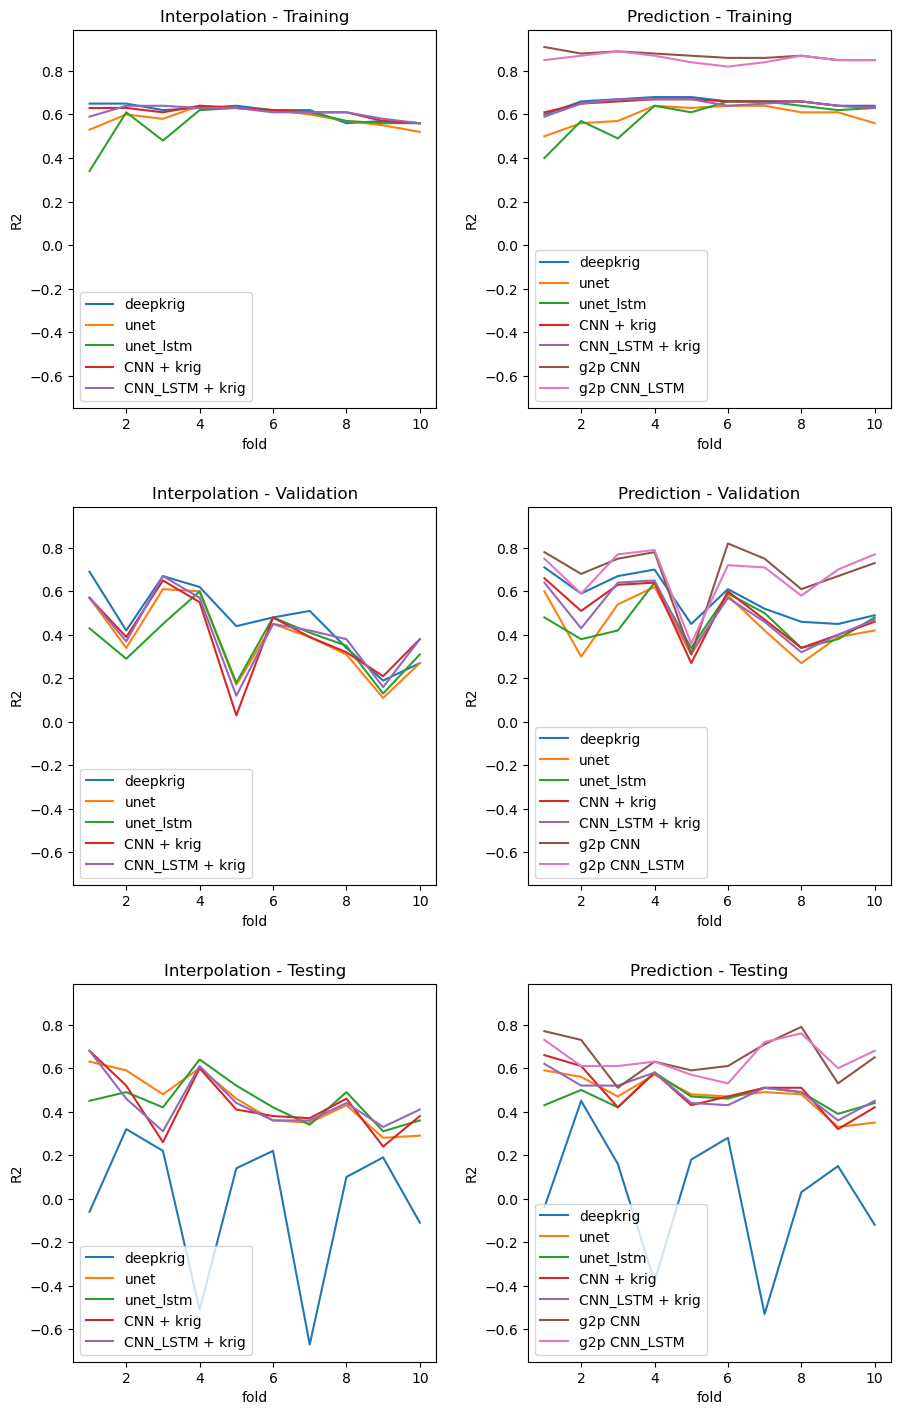

In [18]:
# plot prediction & interpolation depending on the fold
fig, axs = plt.subplots(figsize=(10, 15), nrows=3, ncols=2, sharey=True)
fig.tight_layout(pad=5)
k = range(1,11)
for (label, scores) in [('deepkrig', dk_r2_scores), ('2D unet', unet_2d_r2_scores), 
                ('3D unet', unet_3d_r2_scores), ('CNN + krig', cnn_krig_r2_scores), 
                ('CNN_LSTM + krig', cnn_lstm_krig_r2_scores), ('g2p CNN', cnn_point_r2_scores), 
                ('g2p CNN_LSTM', cnn_lstm_point_r2_scores)]:
    if not label.startswith('g2p'):
        axs[0,0].plot(k, scores['interpolation']['tr'], label=label)
        axs[1,0].plot(k, scores['interpolation']['val'], label=label)
        axs[2,0].plot(k, scores['interpolation']['ts'], label=label)

    axs[0,1].plot(k, scores['prediction']['tr'], label=label)
    axs[1,1].plot(k, scores['prediction']['val'], label=label)
    axs[2,1].plot(k, scores['prediction']['ts'], label=label)

for ax in axs.flatten():
    ax.set_xlabel('fold')
    ax.set_ylabel('R2')
    ax.legend()
    ax.tick_params(axis='y', which='both', labelleft=True)

axs[0,0].set_title('Interpolation - Training')
axs[0,1].set_title('Prediction - Training')
axs[1,0].set_title('Interpolation - Validation')
axs[1,1].set_title('Prediction - Validation')
axs[2,0].set_title('Interpolation - Testing')
axs[2,1].set_title('Prediction - Testing')

fig.savefig('./figs/fold_r2_scores_lines.png')